Create a convolutional neural network using the helper functions and compare the performance with ResNet50 using transfer learning. This notebook contains two sections.

* Section 1 : Create a CNN
* Section 2 : Transfer Lerarning 

Note: The below assignment to set to run with tensorflow version 2.0 and above.

In [ ]:
import tensorflow
print(tensorflow.__version__)

2.8.0


In [ ]:
!pip install tensorflow_ranking

     |████████████████████████████████| 141 kB 5.9 MB/s 
     |████████████████████████████████| 462 kB 45.8 MB/s 


In [ ]:
import pkgutil

# this is the package we are inspecting -- for example 'email' from stdlib
import tensorflow_ranking.python.keras

package = tensorflow_ranking.python.keras
for importer, modname, ispkg in pkgutil.iter_modules(package.__path__):
    print("Found submodule %s (is a package: %s)" % (modname, ispkg))

Found submodule canned (is a package: True)
Found submodule estimator (is a package: False)
Found submodule feature (is a package: False)
Found submodule layers (is a package: False)
Found submodule losses (is a package: False)
Found submodule metrics (is a package: False)
Found submodule model (is a package: False)
Found submodule network (is a package: False)
Found submodule pipeline (is a package: False)
Found submodule saved_model (is a package: False)
Found submodule strategy_utils (is a package: False)
Found submodule utils (is a package: False)


## Import Libraries and load cifar10 dataset.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.applications.resnet import ResNet50
from tensorflow.keras.utils import  to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Activation, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
#import additional libraries if needed
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from keras import regularizers
from tensorflow_ranking.python.keras.metrics import MeanAveragePrecisionMetric


In [ ]:
def load_cifar10_data():
  # Divide the data in Train and Test Datasets
  (x_train,y_train),(x_test,y_test) = cifar10.load_data()
  return (x_train,y_train),(x_test,y_test)

In [ ]:
def convert_to_categorical(y_train, y_test):
  y_train=to_categorical(y_train)
  y_test=to_categorical(y_test)
  return y_train, y_test

In [ ]:
(x_train,y_train),(x_test,y_test) = load_cifar10_data()
y_train, y_test = convert_to_categorical(y_train, y_test)
# Reduce pixel values to range 0-1.
x_train, x_test = x_train / 255.0, x_test / 255.0
# flatten the label values
# y_train, y_test = y_train.flatten(), y_test.flatten()

170508288/170498071 [==============================] - 13s 0us/step


In [ ]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
def plot_3_by_3_images():
  # visualize data by plotting images
  fig, ax = plt.subplots(3, 3)
  k = 0
  
  for i in range(3):
      for j in range(3):
          ax[i][j].imshow(x_train[k], aspect='auto')
          k += 1
  
  plt.show()

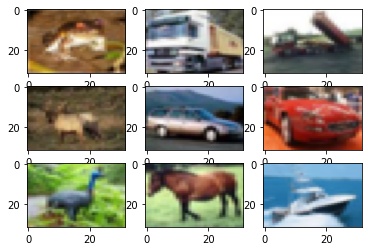

In [ ]:
plot_3_by_3_images()

In [ ]:
display_name = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

def display_image(x, y, index):
    some_image = x[index]
    plt.imshow(some_image, aspect='auto')
    plt.axis('off')
    plt.show()
    label_index = np.argmax(y[index])
    # print(label_index)
    print(display_name.get(label_index))
  


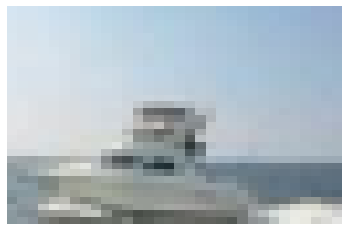

ship


In [ ]:
display_image(x_train, y_train, 100)

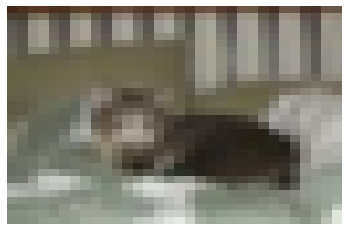

cat


In [ ]:
display_image(x_train, y_train, 150)

## Section 1: Create a convolutional neural network 
Create a convolutional neural network using the helper functions and compare the performance with ResNet50 using transfer learning.


In [ ]:
num_classes = 10
batch_size= 32
epochs = 50
weight_decay = 1e-4

def create_cnn_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))
  
  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))
  
  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))
  
  model.add(Flatten())
  # Selvaraju et al. simply yet ingeniously propose to pass the heatmap through
  # a ReLU function to filter out the negative areas, setting them to zero 
  # importance, while maintaining importance of the positive areas.
  model.add(Dense(256, activation='relu'))
  # Adding name of the layer allows us to use this layer in Grad-CAM mapping
  model.add(Dense(num_classes, activation='softmax', name='visualized_layer'))


 
  return model


def compile_cnn_model(model):
  #TODO Define and compile your model using model.compile(...)
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', MeanAveragePrecisionMetric()])

def compile_cnn_model_2(model):
  #TODO Define and compile your model using model.compile(...)
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


def fit_cnn_model(model, x_train, y_train, batch_size, epochs):
  #TODO Define model.fit(...) with x, y, batch_size, steps_per_epoch, epochs, etc...
  history = model.fit(x_train, y_train, epochs=epochs, batch_size = batch_size, callbacks=[history_logger])
  return history

def eval_cnn_model(model, x_test, y_test):
  scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])


Keras provides the capability to register callbacks when training a model. It is an object that can perform actions at various stages of training like at the start or end of an epoch, before or after a single batch, etc.

In [ ]:
filename='log.csv'
history_logger=tensorflow.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [ ]:
#create model
cnn_model = create_cnn_model()

#compile model
compile_cnn_model(cnn_model)

#fit model
cnn_history = fit_cnn_model(cnn_model, x_train, y_train, batch_size, epochs)


Epoch 1/50
1563/1563 [==============================] - 33s 8ms/step - loss: 1.5855 - accuracy: 0.4445 - mean_average_precision_metric: 0.6327
Epoch 2/50
1563/1563 [==============================] - 13s 8ms/step - loss: 1.2084 - accuracy: 0.5807 - mean_average_precision_metric: 0.7349
Epoch 3/50
1563/1563 [==============================] - 13s 8ms/step - loss: 1.0530 - accuracy: 0.6376 - mean_average_precision_metric: 0.7747
Epoch 4/50
1563/1563 [==============================] - 13s 8ms/step - loss: 0.9622 - accuracy: 0.6679 - mean_average_precision_metric: 0.7957
Epoch 5/50
1563/1563 [==============================] - 14s 9ms/step - loss: 0.8896 - accuracy: 0.6984 - mean_average_precision_metric: 0.8154
Epoch 6/50
1563/1563 [==============================] - 13s 8ms/step - loss: 0.8372 - accuracy: 0.7177 - mean_average_precision_metric: 0.8283
Epoch 7/50
1563/1563 [==============================] - 13s 9ms/step - loss: 0.7968 - accuracy: 0.7311 - mean_average_precision_metric: 0.8374

# Save and load History object With Numpy

A history object has a history field, it is a dictionary that holds different training metrics spanned across every training epoch. So e.g. history.history[‘loss’][10] will return a loss of your model in the 10th epoch of training. In order to save that you could pickle this dictionary.

In [ ]:
np.save('history_my_cnn_b32.npy',cnn_history.history)

history_of_cnn=np.load('history_my_cnn_b32.npy',allow_pickle='TRUE').item()

In [ ]:
#print model summary
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

In [ ]:
cnn_model.history.history.keys()

dict_keys(['loss', 'accuracy', 'mean_average_precision_metric'])

In [ ]:
#evaluate cnn model
eval_cnn_model(cnn_model, x_test, y_test)

79/79 [==============================] - 1s 9ms/step - loss: 0.6299 - accuracy: 0.8389 - mean_average_precision_metric: 0.9048
Test loss: 0.6299034357070923
Test accuracy: 0.8389000296592712


In [ ]:
# install HDF5 for Python to save the model
!pip install h5py

In [ ]:
# Save the model
cnn_model.save("my_cifar_cnn_model_b32")
cnn_model.save("my_cifar_cnn_model_b32.h5")

INFO:tensorflow:Assets written to: my_cifar_cnn_model_b32/assets


# Zip the model to download it

In [ ]:
!zip -r my_cifar_cnn_model_b32.zip my_cifar_cnn_model_b32

  adding: my_cifar_cnn_model_b32/ (stored 0%)
  adding: my_cifar_cnn_model_b32/saved_model.pb (deflated 90%)
  adding: my_cifar_cnn_model_b32/variables/ (stored 0%)
  adding: my_cifar_cnn_model_b32/variables/variables.index (deflated 74%)
  adding: my_cifar_cnn_model_b32/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: my_cifar_cnn_model_b32/assets/ (stored 0%)
  adding: my_cifar_cnn_model_b32/keras_metadata.pb (deflated 94%)


# Section 2: Transfer Learning RESNET

In [ ]:
num_classes = 10
batch_size= 100
epochs = 5

def create_model():
  model = Sequential()
  #TODO Define ResNet50 and any additional layers.
  model_init = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
  
  model.add(UpSampling2D((2,2)))
  model.add(UpSampling2D((2,2)))
  model.add(UpSampling2D((2,2)))
  model.add(model_init)
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())
  model.add(Dense(10, activation='softmax'))

  return model

In [ ]:
def compile_model(model):
  #TODO Define and compile your model using model.compile(...)
  model.compile(optimizer=RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc',MeanAveragePrecisionMetric()])

In [ ]:
def fit_model(model, x_train, y_train, batch_size, epochs):
  #TODO Define model.fit(...) with x, y, batch_size, steps_per_epoch, epochs, etc...
  history = model.fit(x_train, y_train, epochs=epochs, batch_size = 20, validation_data=(x_test, y_test), callbacks=[history_logger])
  return history

In [ ]:
def eval_model(model, x_test, y_test):
  scores = model.evaluate(x_test, y_test, verbose=1)
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])

In [ ]:
filename='log2.csv'
history_logger=tensorflow.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [ ]:
#create model
resnet50_model = create_model()

#compile model
compile_model(resnet50_model)

#fit model
resnet_history = fit_model(resnet50_model, x_train, y_train, batch_size, epochs)


In [ ]:
np.save('history_my_resnet1.npy',resnet50_model.history)

resnet_history=np.load('history_my_resnet1.npy',allow_pickle='TRUE').item()

In [ ]:
resnet50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (20, 64, 64, 3)          0         
 )                                                               
                                                                 
 up_sampling2d_1 (UpSampling  (20, 128, 128, 3)        0         
 2D)                                                             
                                                                 
 up_sampling2d_2 (UpSampling  (20, 256, 256, 3)        0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (20, 131072)              0         
                                                        

In [ ]:
eval_model(resnet50_model, x_test, y_test)

313/313 [==============================] - 81s 243ms/step - loss: 0.1254 - acc: 0.9296 - mean_average_precision_metric: 0.9585
Test loss: 0.1253945678472519
Test accuracy: 0.9296000003814697


In [ ]:
resnet_history.history.keys()

dict_keys(['loss', 'acc', 'mean_average_precision_metric', 'val_loss', 'val_acc', 'val_mean_average_precision_metric'])

In [ ]:
# Save the model
resnet50_model.save("my_cifar_transfer_resnet50_model_no_mean.h5")

# Save the model and zip it so you can download it

In [ ]:
# Save the model
resnet50_model.save("my_cifar_transfer_resnet50_model_no_mean")
!zip -r my_cifar_transfer_resnet50_model_no_mean.zip my_cifar_transfer_resnet50_model_no_mean

INFO:tensorflow:Assets written to: my_cifar_transfer_resnet50_model_no_mean/assets
  adding: my_cifar_transfer_resnet50_model_no_mean/ (stored 0%)
  adding: my_cifar_transfer_resnet50_model_no_mean/assets/ (stored 0%)
  adding: my_cifar_transfer_resnet50_model_no_mean/saved_model.pb (deflated 92%)
  adding: my_cifar_transfer_resnet50_model_no_mean/variables/ (stored 0%)
  adding: my_cifar_transfer_resnet50_model_no_mean/variables/variables.index (deflated 81%)
  adding: my_cifar_transfer_resnet50_model_no_mean/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: my_cifar_transfer_resnet50_model_no_mean/keras_metadata.pb (deflated 96%)


## Compare performance between models

Need to retrieve model due to an expired session on Google Colab

In [ ]:
%cd sample_data

/content/sample_data


In [ ]:
!unzip my_cifar_cnn_model.zip

Archive:  my_cifar_cnn_model.zip
   creating: my_cifar_cnn_model/
   creating: my_cifar_cnn_model/assets/
  inflating: my_cifar_cnn_model/saved_model.pb  
   creating: my_cifar_cnn_model/variables/
  inflating: my_cifar_cnn_model/variables/variables.index  
  inflating: my_cifar_cnn_model/variables/variables.data-00000-of-00001  
  inflating: my_cifar_cnn_model/keras_metadata.pb  


In [ ]:
from tensorflow import keras

# Import the necessary model
from keras.models import load_model

# my_CNN_model = keras.models.load_model("my_cifar_cnn_model")
my_CNN_model = keras.models.load_model('my_cifar_cnn_model', custom_objects={'MeanAveragePrecisionMetric':MeanAveragePrecisionMetric})

In [ ]:
# Evaluate the loaded model after loading weights from tf 
loss, acc_tf, acc_tf_cust = my_CNN_model.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 5s 12ms/step - loss: 0.6747 - accuracy: 0.8554 - mean_average_precision_metric_1: 0.9152


In [ ]:
print("accuracy: {:5.2f}%".format(100*acc_tf))

accuracy: 85.54%


In [ ]:
resnet_loss, resnet_acc, resnet_acc_cust = resnet50_model.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 76s 242ms/step - loss: 0.1254 - acc: 0.9296 - mean_average_precision_metric: 0.9585


# COMPARE

In [ ]:
# plt.subplot(2,1,1)
# plt.plot(my_CNN_model.history['accuracy'],color='r',label='cnn')
# plt.plot(resnet_history.history['val_acc'],color='b',label='resnet50')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['cnn', 'resnet50'], loc='upper left')

# plt.subplot(2,1,2)
# plt.plot(my_CNN_model.history['loss'],color='r',label='cnn')
# plt.plot(resnet_history.history['val_loss'],color='b',label='resnet50')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['cnn', 'resnet50'], loc='lower left')

# plt.tight_layout(pad=1.0) # Add padding between plots
# plt.show()


print("CNN accuracy: {:5.2f}%".format(100*acc_tf))
print("Transfer Learning Resnet50 accuracy: {:5.2f}%".format(100*resnet_acc))
print()
print("CNN mAP: {:5.2f}".format(100*acc_tf_cust))
print("Transfer Learning Resnet50  mAP: {:5.2f}".format(100*resnet_acc_cust))


CNN accuracy: 85.54%
Transfer Learning Resnet50 accuracy: 92.96%

CNN mAP: 91.52
Transfer Learning Resnet50  mAP: 95.85


In [ ]:
# Plotting can be done after nformation about fitting is pulled from hte history that is downloaded